# Prototyping Code for Flight Path Vizualizer

# 1. Plotting and Finding Flight Paths

## 1.1 Plotting flight path from raw CSV

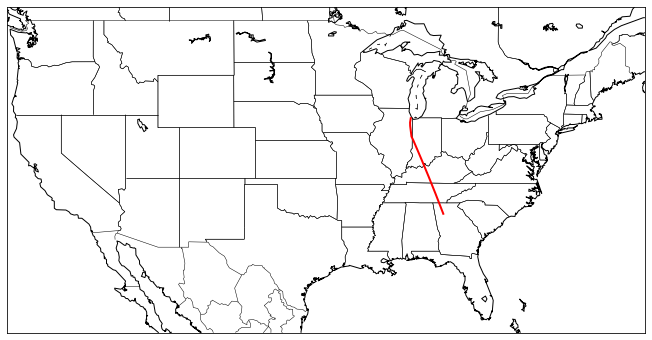

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Path to the csv containing the state vectors for the flight in question
csv_file = 'data/raw_data/Example_Flight_Path.csv'
# ID of flight
# icao24 = 'ad7bdf'
icao24 = 'a2fb32'
# Loading the csv into a dataframe
flight_path = pd.read_csv(csv_file).dropna()
flight_path = flight_path[flight_path['icao24'] == icao24]

# Loading latitutes and longitudes
lats = flight_path['lat']
lons = flight_path['lon']

fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the latitude and longitude bounds to focus on the US
m = Basemap(projection='mill',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-66,resolution='l', ax=ax)  # 'l' for low resolution

m.drawcoastlines()
m.drawcountries()
m.drawstates()  # To draw state boundaries

x, y = m(lons, lats)

# Plot the transformed coordinates on the map
m.plot(x, y, 'r-', markersize=5, linewidth=2)

plt.show()


## 1.2 Compressing data into small file for interpolation

Compression: 99.94


/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3838428172.py:107: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3838428172.py:111: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')


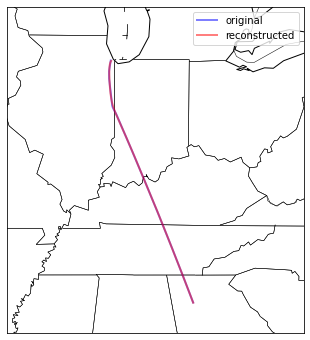

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from simplification.cutil import simplify_coords
from scipy.interpolate import UnivariateSpline
import pickle as pkl
import os

# Path to the csv containing the state vectors for the flight in question
csv_file = 'data/raw_data/Example_Flight_Path.csv'
# ID of flight
# icao24 = 'ad7bdf'
icao24 = 'a2fb32'
# Path to spline file
spline_file = 'data/raw_data/Example_Flight_Path.pkl'
# Loading the csv into a dataframe and cleaning it up
flight_path = pd.read_csv(csv_file).dropna().drop(['callsign', 'spi', 'squawk', 'lastposupdate', 'lastcontact'], axis = 'columns')
flight_path = flight_path[flight_path['icao24'] == icao24]
flight_path = flight_path[flight_path['onground'] == False]
flight_path = flight_path.drop(['onground', 'icao24'], axis = 'columns')
flight_path['altitude'] = 0.5*(flight_path['geoaltitude'] + flight_path['baroaltitude'])
flight_path = flight_path.drop(['geoaltitude', 'baroaltitude'], axis = 'columns')

def spline_maker(flight_path, icao24, filename):
    """
    Create a spline representation of a flight path and save it to a file.
    
    Parameters:
        flight_path (DataFrame): The flight path data.
        icao24 (str): An ID referring to the flight.
        filename (str): Name of the file to save the spline.
        
    Returns:
        None
    """
    x = flight_path['time'].values
    
    splines = {}
    for column in ['lat', 'lon', 'velocity', 'altitude']:
        y = flight_path[column].values
        spline = UnivariateSpline(x, y, s=0.01)
        splines[column] = spline

    # Save the splines, icao24, start time, and end time to a file
    data = {
        'icao24': icao24,
        'start_time': x[0],
        'end_time': x[-1],
        'splines': splines
    }
    with open(spline_file, 'wb') as f:
        pkl.dump(data, f)
    return data


def spline_reader(data, ts):
    """
    Read a spline representation from a file and rebuild the flight path using given time intervals.
    
    Parameters:
        filename (str): Name of the file containing the spline representation.
        time_intervals (array-like): Time intervals at which to rebuild the path.
        
    Returns:
        reconstructed_path (DataFrame): The reconstructed flight path data.
    """
    
    splines = data['splines']
    reconstructed_data = {'time': ts}
    
    for column, spline in splines.items():
        reconstructed_data[column] = spline(ts)
        
    reconstructed_path = pd.DataFrame(reconstructed_data)
    
    return reconstructed_path

# Example usage:
data = spline_maker(flight_path, 'a2fb32', 'spline_representation.pkl')
ts = np.linspace(flight_path['time'].values[0], flight_path['time'].values[-1], num=1000)  # You can adjust start_time, end_time, and num as required
reconstructed_path = spline_reader('spline_representation.pkl', ts)

size_original = os.path.getsize(csv_file)
size_spline = os.path.getsize(spline_file)

print("Compression: " + str(round(100 - 100*size_spline/size_original, 2)))

lons_original = flight_path['lon']
lons_reconstructed = reconstructed_path['lon']
lats_original = flight_path['lat']
lats_reconstructed = reconstructed_path['lat']

fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the latitude and longitude bounds to focus on the US
m = Basemap(projection='mill',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-66,resolution='l', ax=ax)  # 'l' for low resolution

m.drawcoastlines()
m.drawcountries()
m.drawstates()  # To draw state boundaries

x, y = m(lons_original, lats_original)

# Plot the transformed coordinates on the map
m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')

x, y = m(lons_reconstructed, lats_reconstructed)

m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')

rangeX = max(x) - min(x)
rangeY = max(y) - min(y)
ax.set_xlim([0.9*min(x), 1.1*max(x)])
ax.set_ylim([0.9*min(y), 1.1*max(y)])
ax.legend()

plt.show()

## 1.3 Computing shortest path from $x_0$, $y_0$, to $x_f$, $y_f$

/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3067399314.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3067399314.py:99: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3067399314.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'green', alpha = 0.5, lab

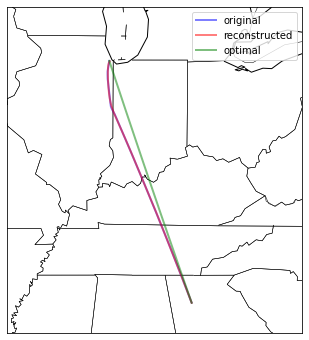

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from simplification.cutil import simplify_coords
from scipy.interpolate import UnivariateSpline
import pickle as pkl
import os

# Path to the csv containing the state vectors for the flight in question
csv_file = 'data/raw_data/Example_Flight_Path.csv'
# ID of flight
# icao24 = 'ad7bdf'
icao24 = 'a2fb32'
# Path to spline file
spline_file = 'data/raw_data/Example_Flight_Path.pkl'
# Loading the csv into a dataframe and cleaning it up
flight_path = pd.read_csv(csv_file).dropna().drop(['callsign', 'spi', 'squawk', 'lastposupdate', 'lastcontact'], axis = 'columns')
flight_path = flight_path[flight_path['icao24'] == icao24]
flight_path = flight_path[flight_path['onground'] == False]
flight_path = flight_path.drop(['onground', 'icao24'], axis = 'columns')
flight_path['altitude'] = 0.5*(flight_path['geoaltitude'] + flight_path['baroaltitude'])
flight_path = flight_path.drop(['geoaltitude', 'baroaltitude'], axis = 'columns')

def spline_reader(data, ts):
    """
    Read a spline representation from a file and rebuild the flight path using given time intervals.
    
    Parameters:
        filename (str): Name of the file containing the spline representation.
        time_intervals (array-like): Time intervals at which to rebuild the path.
        
    Returns:
        reconstructed_path (DataFrame): The reconstructed flight path data.
    """
    
    splines = data['splines']
    reconstructed_data = {'time': ts}
    
    for column, spline in splines.items():
        reconstructed_data[column] = spline(ts)
        
    reconstructed_path = pd.DataFrame(reconstructed_data)
    
    return reconstructed_path

precision = 1000
lat_0 = flight_path.iloc[0]['lat']
lon_0 = flight_path.iloc[0]['lon']

lat_f = flight_path.iloc[-1]['lat']
lon_f = flight_path.iloc[-1]['lon']

tht_0 = (90 - lat_0)/180*np.pi
phi_0 = (lon_0)/180*np.pi

tht_f = (90 - lat_f)/180*np.pi
phi_f = (lon_f)/180*np.pi

dphi = phi_f - phi_0
if abs(dphi) > np.pi:
    dphi = -(2*np.pi - abs(dphi))

phis_opt = np.linspace(phi_0, phi_0 + dphi, num = precision)
# phis_opt[phis_opt < 0] = phis_opt[phis_opt < 0] + 2*np.pi

thts_opt = np.linspace(tht_0, tht_f, num = precision)

lons_optimal = phis_opt/np.pi*180
lats_optimal = 90 - thts_opt/np.pi*180


with open(spline_file, 'rb') as f:
    data = pkl.load(f)
reconstructed_path = spline_reader(data, ts)

lons_original = flight_path['lon']
lons_reconstructed = reconstructed_path['lon']
lats_original = flight_path['lat']
lats_reconstructed = reconstructed_path['lat']

fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the latitude and longitude bounds to focus on the US
m = Basemap(projection='mill',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-66,resolution='l', ax=ax)  # 'l' for low resolution

m.drawcoastlines()
m.drawcountries()
m.drawstates()  # To draw state boundaries

x, y = m(lons_original, lats_original)

# Plot the transformed coordinates on the map
m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')

x, y = m(lons_reconstructed, lats_reconstructed)

m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')

x, y = m(lons_optimal, lats_optimal)

m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'green', alpha = 0.5, label = 'optimal')

rangeX = max(x) - min(x)
rangeY = max(y) - min(y)
ax.set_xlim([0.9*min(x), 1.1*max(x)])
ax.set_ylim([0.9*min(y), 1.1*max(y)])
ax.legend()

path_divergence = 

plt.show()

## 1.4 Computing "Ideal path" from $x_0$, $y_0$, to $x_f$, $y_f$ considering the Coriollis effect
This is the code to compute the ideal path between two points in a rotating sphere given the coriolis effect.
This does not take altitude or velocity into consideration.

The coriolis acceleration can be described as:
$$a_c = -2\vec{\omega}\times\dot{\vec{r}}$$
Where $\vec{\omega}$ is the angular rotation vector of the sphere (Earth),
and $\vec{r}$ is the position vector of the aircraft with the origin at the center of the earth, and the dot notations indicates a time derivative.

We'll work under the following assumptions and conventions:
 - The aricraft does not leave the surface of the Earth (ignoring altitude).
 - The Earth is a perfect sphere
 - $r$ is the radial distance $r = R_e = constant$
 - $\theta$ is the polar angle $[0, \pi]$
 - $\phi$ is the azimuthal angle $[0, 2\pi)$
 - The rotation of the earth is aligned with $\hat{z}$
 - The airfract applies constant thrust thorugh the journey

Thus, at any position $\vec{r}$, we know the forces acting on the aircraft should be:

$$\vec{F} = m \ddot{\vec{r}} = F_T\hat{\dot{r}} -2m\vec{\omega}\times\dot{\vec{r}}$$

Where $F_T$ is the constant thrust force in Newtons applied by the plane, $\hat{\dot{r}}$ is the heading of the plane, $\ddot{\vec{r}}$ is the acceleration of the plane, and $m$ is the mass of the plane.

We can simplify this with the new quantity $T_W$ as the Thrust-to-Weight ratio, defined as $T_W = \frac{F_T}{m g}$

$$\ddot{\vec{r}} = gT_w\hat{\dot{r}} - 2\vec{\omega}\times\dot{\vec{r}}$$

Now it's a matter of extremizing $r(t)$ such that it minimizes some quantity btween the two positions under the constraint

$$|\vec{r}| = R_e$$

There are two paths to consider:
 - Path that minimizes the total distance
 - Path that minimizes the total travel time (not the same, because of coriolis force)
Sinze we're considering constant thrust, the path that minimized time is also the same that minimizes fuel expense.

Let's focus on the path that minimizes the time.

$$T = \int_{\vec{r}_0}^{\vec{r}_f} dt$$

(cont...)

# 2. Accessing data

## 2.1 Accessing Opensky-Network database through python ssh+querying

In [65]:
import paramiko
import pandas as pd
import yaml
# ssh -p 2230 -l andrerg01 data.opensky-network.org

def to_number(s):
    try:
        # Try to convert to an integer
        return int(s)
    except ValueError:
        try:
            # Try to convert to a floating-point number
            return float(s)
        except ValueError:
            # Not a number
            return s
        
def parse_to_dataframe(results):
    # Splits the result into lines
    lines = results.split('\n')
    # Array to save the lines containing data
    good_lines = []
    # Sample of first line to further ignore
    first_line = lines[0]
    # Line containing column names
    columns_line = lines[1]
    # Looping thorugh lines and saving data
    for i in range(1, len(lines)-1):
        if lines[i] == columns_line or lines[i] == first_line:
            pass
        else:
            good_lines += [lines[i]]
    # Cleaning data and turning strings to arrays
    for i, line in enumerate(good_lines):
        good_lines[i] = line.replace(' ','').replace('\t','').split('|')[1:-1]
    # Getting column names
    columns = columns_line.replace(' ','').replace('\t','').split('|')[1:-1]

    # Turning arrays of data and columns into a dataframe
    good_lines = np.array(good_lines).T
    df_dict = {col: good_lines[i] for i,col in enumerate(columns)}
    return pd.DataFrame(df_dict).applymap(to_number) 
    

with open('pvt/opensky_login.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
        username = config['opensky']['username']
        password = config['opensky']['password']
    except yaml.YAMLError as exc:
        print(exc)
        
# SSH configurations
hostname = 'data.opensky-network.org'
port = 2230

# Initialize SSH client
client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(hostname, port=port, username=username, password=password)

# Run a command in Impala Shell
querry = """SELECT callsign, icao24, firstseen, lastseen, estdepartureairport, estarrivalairport 
FROM flights_data4 
WHERE estdepartureairport = 'KBTR' 
AND estarrivalairport = 'KDFW';"""

# Run a command in Impala Shell using the -q option
cmd = "-q " + querry

stdin, stdout, stderr = client.exec_command(cmd)

# Fetch results
results = stdout.read().decode()
errors = stderr.read().decode()

client.close()

res = parse_to_dataframe(results)
res

,callsign,icao24,firstseen,lastseen,estdepartureairport,estarrivalairport
0,ASH5794,ac8287,1667325133,1667328939,KBTR,KDFW
1,SKW3185,a9b402,1641176681,1641180605,KBTR,KDFW
2,SKW3181,aa8859,1672864352,1672868315,KBTR,KDFW
3,ASH5837,ad247c,1672850431,1672854329,KBTR,KDFW
4,ENY3724,a1c5e0,1672800817,1672804461,KBTR,KDFW
...,...,...,...,...,...,...
2564,ENY3761,a24ef0,1692547121,1692550395,KBTR,KDFW
2565,SKW3090,a96c72,1658331757,1658335431,KBTR,KDFW
2566,SKW3087,aa5d23,1658349674,1658353086,KBTR,KDFW
2567,SKW3087,aa596c,1661125612,1661129284,KBTR,KDFW


In [71]:
flight = res.iloc[0]

client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(hostname, port=port, username=username, password=password)

# Run a command in Impala Shell
querry = """SELECT lat, lon 
FROM state_vectors_data4 
WHERE icao24 = \''""" + flight['icao24'] + """\' 
AND time > """ + str(flight['firstseen']) + """ 
AND time < """ + str(flight['lastseen']) + """;"""
# Run a command in Impala Shell using the -q option
cmd = "-q " + querry

stdin, stdout, stderr = client.exec_command(cmd)

# Fetch results
results = stdout.read().decode()
errors = stderr.read().decode()

client.close()

res = parse_to_dataframe(results)
res

IndexError: list index out of range

In [74]:
errors

"Starting Impala Shell without Kerberos authentication\nERROR: AnalysisException: Syntax error in line 3:\nWHERE icao24 = ''ac8287' \n                 ^\nEncountered: IDENTIFIER\nExpected: AND, BETWEEN, DIV, GROUP, HAVING, ILIKE, IN, IREGEXP, IS, LIKE, LIMIT, NOT, OFFSET, OR, ORDER, REGEXP, RLIKE, UNION\n\nCAUSED BY: Exception: Syntax error\n\nCould not execute command: SELECT lat, lon \nFROM state_vectors_data4 \nWHERE icao24 = ''ac8287' \nAND time > 1667325133 \nAND time < 1667328939\n"

In [75]:
str(flight['lastseen'])

'1667328939'

In [148]:
# Convert UNIX time to date UTC
from datetime import datetime

def unix_to_utc(unix_time):
    return datetime.utcfromtimestamp(unix_time)

def utc_to_unix(utc_time):
    return int(utc_time.timestamp())

unix_time = 1693786186
utc_time = unix_to_utc(unix_time)
unix_time = utc_to_unix(utc_time)
print(utc_time)
print(unix_time)

2023-09-04 00:09:46
1693753786


## 2.2 Accessing OpenSky data through opensky-api
https://openskynetwork.github.io/opensky-api/python.html

cloned and installed from src/backend/opensky-api

### 2.2.1 Loading API

In [1]:
from opensky_api import OpenSkyApi
import pandas as pd
import yaml

with open('pvt/opensky_login.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
        username = config['opensky']['username']
        password = config['opensky']['password']
    except yaml.YAMLError as exc:
        print(exc)
        
api = OpenSkyApi(username, password)

{'states': [], 'time': 0}


### 2.2.2 Getting Flight Data from time interval

In [2]:
data = api.get_flights_from_interval(1517227200, 1517230800)
for flight in data:
    print(flight)


{   'arrivalAirportCandidatesCount': 1,
    'callsign': 'SWG9426 ',
    'departureAirportCandidatesCount': 1,
    'estArrivalAirport': 'CYUL',
    'estArrivalAirportHorizDistance': 3244,
    'estArrivalAirportVertDistance': 81,
    'estDepartureAirport': 'CYYZ',
    'estDepartureAirportHorizDistance': 525,
    'estDepartureAirportVertDistance': 104,
    'firstSeen': 1517227317,
    'icao24': 'c078fd',
    'lastSeen': 1517230676}
{   'arrivalAirportCandidatesCount': 1,
    'callsign': 'JAL920  ',
    'departureAirportCandidatesCount': 0,
    'estArrivalAirport': 'RJTK',
    'estArrivalAirportHorizDistance': 15167,
    'estArrivalAirportVertDistance': 1421,
    'estDepartureAirport': None,
    'estDepartureAirportHorizDistance': None,
    'estDepartureAirportVertDistance': None,
    'firstSeen': 1517229296,
    'icao24': '8686b2',
    'lastSeen': 1517230536}
{   'arrivalAirportCandidatesCount': 2,
    'callsign': 'ONE6105 ',
    'departureAirportCandidatesCount': 0,
    'estArrivalAirpor

### 2.2.3 Getting Flight Data from aircraft and time interval

In [6]:
data = api.get_flights_by_aircraft("3c675a", 1517184000, 1517270400)
for flight in data:
    print(flight)

{   'arrivalAirportCandidatesCount': 3,
    'callsign': 'DLH2VC  ',
    'departureAirportCandidatesCount': 1,
    'estArrivalAirport': 'ESSA',
    'estArrivalAirportHorizDistance': 7194,
    'estArrivalAirportVertDistance': 423,
    'estDepartureAirport': 'EDDF',
    'estDepartureAirportHorizDistance': 1462,
    'estDepartureAirportVertDistance': 49,
    'firstSeen': 1517258040,
    'icao24': '3c675a',
    'lastSeen': 1517263900}
{   'arrivalAirportCandidatesCount': 3,
    'callsign': 'DLH1RP  ',
    'departureAirportCandidatesCount': 0,
    'estArrivalAirport': 'EDDF',
    'estArrivalAirportHorizDistance': 4478,
    'estArrivalAirportVertDistance': 110,
    'estDepartureAirport': None,
    'estDepartureAirportHorizDistance': None,
    'estDepartureAirportVertDistance': None,
    'firstSeen': 1517249610,
    'icao24': '3c675a',
    'lastSeen': 1517253348}
{   'arrivalAirportCandidatesCount': 0,
    'callsign': 'DLH830  ',
    'departureAirportCandidatesCount': 1,
    'estArrivalAirport

In [12]:
flight = data[5]
icao24 = flight.icao24
mid_time = int((flight.firstSeen + flight.lastSeen)/2)

### 2.2.4 Getting Flight Track by aircraft
Limited to 30 days in the past

In [15]:
api = OpenSkyApi()
track = api.get_track_by_aircraft("3c4b26")
print(track)

{   'callsign': 'DLH455  ',
    'endTime': 1694307860.0,
    'icao24': '3c4b26',
    'path': [   [1694298011, 37.621, -122.3804, -304, 297, False],
                [1694298050, 37.6348, -122.4133, 0, 297, False],
                [1694298091, 37.6507, -122.4501, 304, 298, False],
                [1694298133, 37.6675, -122.4896, 609, 298, False],
                [1694298150, 37.6748, -122.5058, 914, 300, False],
                [1694298164, 37.6834, -122.5185, 914, 322, False],
                [1694298178, 37.6954, -122.5249, 914, 349, False],
                [1694298183, 37.7008, -122.5256, 914, 358, False],
                [1694298219, 37.7418, -122.5256, 914, 357, False],
                [1694298242, 37.7705, -122.5267, 1219, 358, False],
                [1694298253, 37.7839, -122.5265, 1219, 2, False],
                [1694298261, 37.7956, -122.5236, 1219, 16, False],
                [1694298277, 37.8138, -122.5115, 1524, 36, False],
                [1694298290, 37.8279, -122.4952, 1

# Getting states for arbitrary flight at arbitrary time.
Only allows one set per time chosen, need to loop thorugh times

Estimated time ~ (3 * Number of pings) seconds.
Very ineficient, if we can find a way to do this through the SSH method, that'd be dope

In [60]:
import numpy as np
import time

data = api.get_flights_by_aircraft("3c675a", 1517184000, 1517270400)
flight = data[5]
icao24 = flight.icao24
t0 = flight.firstSeen
tf = flight.lastSeen

values = {'time':[], 'lat':[], 'lon':[]}
for t in np.linspace(t0, tf, num = 10, endpoint = True).astype(int):
    print(t, values)
    l0 = len(values['time'])
    while len(values['time']) == l0:
        try:
            # Client-side imposed limit, easy to hack around, but I don't wanna anger the OpenSky gods...
            time.sleep(2.5)
            state = api.get_states(time_secs = t, icao24 = icao24).states[0]
            values['time'] += [state.time_position]
            values['lat'] += [state.latitude]
            values['lon'] += [state.longitude]
        except:
            pass
        
    
values

1517216755 {'time': [], 'lat': [], 'lon': []}
1517217072 {'time': [1517216722], 'lat': [52.5601], 'lon': [13.3095]}
1517217389 {'time': [1517216722, 1517217071], 'lat': [52.5601, 52.4007], 'lon': [13.3095, 12.8325]}
1517217706 {'time': [1517216722, 1517217071, 1517217389], 'lat': [52.5601, 52.4007, 52.0646], 'lon': [13.3095, 12.8325, 12.1748]}
1517218023 {'time': [1517216722, 1517217071, 1517217389, 1517217705], 'lat': [52.5601, 52.4007, 52.0646, 51.6911], 'lon': [13.3095, 12.8325, 12.1748, 11.4635]}
1517218340 {'time': [1517216722, 1517217071, 1517217389, 1517217705, 1517218023], 'lat': [52.5601, 52.4007, 52.0646, 51.6911, 51.3253], 'lon': [13.3095, 12.8325, 12.1748, 11.4635, 10.7855]}
1517218657 {'time': [1517216722, 1517217071, 1517217389, 1517217705, 1517218023, 1517218339], 'lat': [52.5601, 52.4007, 52.0646, 51.6911, 51.3253, 50.956], 'lon': [13.3095, 12.8325, 12.1748, 11.4635, 10.7855, 10.2547]}
1517218974 {'time': [1517216722, 1517217071, 1517217389, 1517217705, 1517218023, 1517

{'time': [1517216722,
  1517217071,
  1517217389,
  1517217705,
  1517218023,
  1517218339,
  1517218656,
  1517218973,
  1517219290,
  1517219607],
 'lat': [52.5601,
  52.4007,
  52.0646,
  51.6911,
  51.3253,
  50.956,
  50.5838,
  50.2777,
  50.1064,
  50.0385],
 'lon': [13.3095,
  12.8325,
  12.1748,
  11.4635,
  10.7855,
  10.2547,
  9.7332,
  9.2222,
  8.7882,
  8.5084]}

In [52]:
state = api.get_states(time_secs = t, icao24 = icao24).states[0]
values['time'] += [state.time_position]
values['lat'] += [state.latitude]
values['lon'] += [state.longitude]

In [53]:
values

{'time': [1517219607], 'lat': [50.0385], 'lon': [8.5084]}

In [47]:
api.get_states(time_secs = t, icao24 = icao24).time

1517219608

In [ ]:
time